In [1]:
import pandas as pd
import faiss 
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image 
import pickle 
from tqdm import tqdm 
import matplotlib.pyplot as plt
import random

from openai import OpenAI

import base64
import requests

import json
import re 

In [2]:

def show_image(image_paths, sentence=None):


    k=(len(image_paths)+4)//5 
    fig, axs = plt.subplots(nrows=k, ncols=5, figsize=(20, 8))  
    axs = axs.flatten()  

    
    for ax, img_path in zip(axs, image_paths):
        try:
            img = Image.open(img_path)
            ax.imshow(img)
            ax.axis('off')  
            ax.set_title(img_path.split('/')[-1])  
        except FileNotFoundError:
            ax.imshow(np.zeros((10, 10, 3), dtype=int))  
            ax.axis('off')
            ax.set_title('File Not Found')
    if sentence:
        fig.suptitle(sentence, fontsize=16)
    plt.tight_layout()
    plt.show()



class ImageEmbedder:
    def __init__(self, model, preprocessor):
        """ model projects image to vector, processor load and prepare image to the model"""
        self.model = model
        self.processor = preprocessor

def BLIP_BASELINE():
    from torchvision import transforms
    from torchvision.transforms.functional import InterpolationMode

    import sys
    sys.path.insert(0, './BLIP')
    from BLIP.models.blip_itm import blip_itm
    # load model
    model = blip_itm(pretrained='./BLIP/chatir_weights.ckpt',  # Download from Google Drive, see README.md
                     med_config='BLIP/configs/med_config.json',
                     image_size=224,
                     vit='base'
                     )

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device).eval()

    # define Image Embedder (raw_image --> img_feature)
    transform_test = transforms.Compose([
        transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    ])

    def blip_project_img(image):
        embeds = model.visual_encoder(image)
        projection = model.vision_proj(embeds[:, 0, :])
        return F.normalize(projection, dim=-1)

    def blip_prep_image(path):
        raw = Image.open(path).convert('RGB')
        return transform_test(raw)

    image_embedder = ImageEmbedder(blip_project_img, lambda path: blip_prep_image(path))

    # define dialog encoder (dialog --> img_feature)
    def dialog_encoder(dialog):
        text = model.tokenizer(dialog, padding='longest', truncation=True,
                               max_length=200,
                               return_tensors="pt"
                               ).to(device)

        text_output = model.text_encoder(text.input_ids, attention_mask=text.attention_mask,
                                         return_dict=True, mode='text')

        shift = model.text_proj(text_output.last_hidden_state[:, 0, :])
        return F.normalize(shift, dim=-1)

    return dialog_encoder, image_embedder

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts: list):
        """
        Args:
            texts (list of str): List of text strings.
            processor (transformers processor): Processor to tokenize the text.
        """
        self.texts = texts
        # self.processor = processor

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]  # Get the text at the provided index
        return {'text': text}

def encode_text(dataset, model):
    """CLIP for encode text """
    # model.eval()
    data_loader = torch.utils.data.DataLoader(dataset,
                                              batch_size=20,
                                              pin_memory=True,
                                              num_workers=1,
                                              prefetch_factor=2,
                                              shuffle=False,
                                              
                                              )
    all_features = []
    with torch.no_grad():
        for batch in data_loader:
            features = model(batch['text'])
            all_features.append(features.cpu())  
    return torch.cat(all_features)  

def retrieve_topk_images(query: list,
                         topk=10,
                         faiss_model=None,
                         blip_model=None,
                         id2image=None,
                         processor=None, ):
    text_dataset = TextDataset(query)
    query_vec = encode_text(text_dataset, blip_model)
    query_vec = query_vec.numpy()
    query_vec /= np.linalg.norm(query_vec, axis=1, keepdims=True)

    # print(f"faiss_model vector dimension (d): {faiss_model.d}")
    # print(f"Query vector dimension: {query_vec.shape}")
    distance, indices = faiss_model.search(query_vec, topk)
    indices = np.array(indices)
    image_paths = [[id2image.get(idx, 'path/not/found') for idx in row] for row in indices]
    return image_paths, indices



def find_index_in_list(element, my_list):
    return my_list.index(element) 


In [3]:


def generate_valid_question(base64_image_top, system_prompt, previous_questions, max_retries=5):
    """
    。
    """
    for attempt in range(max_retries):
        try:
            # print(f"Attempt {attempt + 1} to generate a valid question.")

            
            question_fewshot = question_attribute(base64_image_top, system_prompt, previous_questions)

            
            question_fewshot_json = extract_json(question_fewshot)

            if question_fewshot_json:
                question_fewshot_json = json.loads(question_fewshot_json)  
                if "Question to differentiate the pictures" in question_fewshot_json:
                    return question_fewshot_json["Question to differentiate the pictures"]
                else:
                    print(f"Key 'Question to differentiate the pictures' not found, retrying...")

        except json.JSONDecodeError:
            print("JSONDecodeError: The result is not valid JSON, retrying...")
        except KeyError:
            print("KeyError: Expected key not found in the generated JSON, retrying...")
        except Exception as e:
            print(f"An unexpected error occurred: {e}, retrying...")
        
        
        attempt += 1


    print("Failed to generate a valid question after multiple attempts.")
    return None


In [4]:
def extract_json(text):
    pattern = r'{.*}'
    match = re.search(pattern, text, re.DOTALL)
    if match:
        return match.group()
    else:
        return 'parse incorrectly'

In [5]:
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

In [6]:

def answer(question,base64_target_image):
    client = OpenAI(api_key=,base_url = "") 
    
    response = client.chat.completions.create(
      model="",
      messages=[
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": f"according to the image, answer the question:{question}, Your answer must be direct and simple",
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_target_image}",
              },
            }
          ],
        }
      ],
      max_tokens=100,
    )
    return response.choices[0].message.content

In [7]:
system_prompt = """
You are an assistant that helps users to differentiate between images by generating specific, non-repetitive questions based on given images. 
Given 5 pictures and a list of questions you have previously asked, your task is to find common objects that appear in all 5 pictures but have distinguishing features. Based on these objects, ask a question that is not included in [previous questions] to differentiate the pictures.
Make sure the question is specific, directly related to the images, and not abstract. Avoid repeating the same attributes mentioned in any previous questions. And don't ask two questions at the same time, such as 'What is the attribute of a or b?'.


For example:
Example 1: All 5 pictures have people, but the number of people differs. You can ask about the number of people.
Example 2: All 5 pictures have cats, but the colors are different. You can ask about the color.
Example 3: All 5 pictures have traffic lights, but their positions differ. You can ask about the position of the traffic lights.


ensure that the output strictly(have to !) follows this JSON format:
{
"What is the common object that appears in all five pictures":"Answer1",
"What is the distinguishing feature that can help differentiate the picture":"Answer2",
"Question to differentiate the pictures":"Answer3"
}
The output should not contain any extra characters or text outside of this JSON structure.

"""

In [8]:

def question_attribute(base64_image_list, system_prompt, previous_questions):
    client = OpenAI(api_key=, base_url="")  

    
    previous_questions_text = " ".join([f'Previous Question: {q}' for q in previous_questions])
    # print("Previous_Question:",previous_questions)
    
    user_prompt = f"""
    [Previous questions]: {previous_questions_text}.
    """
    messages = [
        {"role": "system", "content": [{"type": "text", "text": system_prompt}]},  
        {"role": "user","content": [{"type": "text", "text": user_prompt}]},  
      ]
        
    for img_base64 in base64_image_list:
        messages.append({
            "role": "user",
            "content": [{
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"}
            }]
        })

    response = client.chat.completions.create(
      model="",
      messages=messages,
      max_tokens=500,
    )
    
    return response.choices[0].message.content


In [9]:

def summary(query,question,answer):
    client = OpenAI(api_key=,base_url = "") 
    
    response = client.chat.completions.create(
    model="",
    messages=[
        {"role": "system", "content": f"""
        Your task is to summarize the information from the image's question and answer and add this information to the original image description.\
        Remember: the summarized information must be concise, and the original description should not be altered.

        <question>
        {question}
        <answer>
        {answer}
        <image description>
        {query}


The information extracted from the question and answer should be added to the original description as an attribute or a simple attributive clause.
        """
        },
        {"role": "user", "content": ""}
      ]
    )
    return response.choices[0].message.content

In [ ]:
import faiss
import pickle

try:
    print("Load faiss Model...")
    faiss_model = faiss.read_index('./checkpoints/blip_faiss.index')
    print("faiss faiss Model Load successful")
except Exception as e:
    print(f"Error: {e}")

try:
    print("Load id2image Data...")
    with open('./checkpoints/id2image.pickle', 'rb') as f:
        id2image = pickle.load(f)
    print("id2image DataLoad Successful")
except Exception as e:
    print(f"Load id2image Error: {e}")

try:
    print("Load image_vector Data...")
    with open('./checkpoints/blip_image_embedding.pickle', 'rb') as f:
        image_vector = pickle.load(f)
    print("image_vector DataLoad Successful")
except Exception as e:
    print(f"Load image_vector Error: {e}")


Load faiss Model...
faiss faiss Model Load successful
Load id2image Data...
id2image DataLoad Successful
Load image_vector Data...
image_vector DataLoad Successful


In [11]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('/root/autodl-tmp/.autodl/HYF/questionIR/CSS/MODELS/bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('/root/autodl-tmp/.autodl/HYF/questionIR/CSS/MODELS/bert-base-uncased') 


/root/anaconda3/envs/new_questionIR/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/root/anaconda3/envs/new_questionIR/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:

faiss_model = faiss.read_index('./checkpoints/blip_faiss.index')
with open('./checkpoints/id2image.pickle', 'rb') as f:
    id2image = pickle.load(f)
    
with open('./checkpoints/blip_image_embedding.pickle', 'rb') as f:
    image_vector = pickle.load(f)
dialog_encoder, image_embedder = BLIP_BASELINE()

load checkpoint from ./BLIP/chatir_weights.ckpt


In [13]:

class DataLoader:
    def load_data(self):
        raise NotImplementedError("This method should be covered by subclass")

In [14]:

class CSVDataLoader(DataLoader):
    def __init__(self, file_path):
        self.file_path = file_path

    def load_data(self):
        return pd.read_csv(self.file_path)

In [15]:
from datasets import load_dataset

class HuggingFaceDataLoader(DataLoader):
    def __init__(self, dataset_name, split):
        self.dataset_name = dataset_name
        self.split = split

    def load_data(self):
        dataset = load_dataset(self.dataset_name, split=self.split)
        return dataset.to_pandas()  

In [16]:

def get_data_loader(file_type, file_path=None, dataset_name=None, split=None):
    if file_type == "csv":
        return CSVDataLoader(file_path)
    elif file_type == "huggingface":
        return HuggingFaceDataLoader(dataset_name, split)
    else:
        raise ValueError(f"Unsupported file type: {file_type}")

In [17]:
def read_csv(file_path):

    data = pd.read_csv(file_path)
    return data

In [18]:
'''

file_path = '/root/autodl-tmp/.autodl/HYF/questionIR/CSS/downloads/group_20-50.csv'
csv_data = read_csv(file_path)

print(csv_data.shape)  
'''

"\n\nfile_path = '/root/autodl-tmp/.autodl/HYF/questionIR/CSS/downloads/group_20-50.csv'\ncsv_data = read_csv(file_path)\n\nprint(csv_data.shape)  \n"

In [19]:
# csv_data.head()

(222, 5)
Round 1:
new -> question: What type of event or activity are the people engaged in?, answer_of_question: They are attending a formal or celebratory event.
query_with_feedback: Initial Query: a group of people having some sort of celebration, question: What type of event or activity are the people engaged in?, answer_of_question: They are attending a formal or celebratory event.
query_with_feedback: Initial Query: a group of people having some sort of celebration Question: What type of event or activity are the people engaged in? Answer: They are attending a formal or celebratory event., 
Old Rank: 350, New Rank: 231


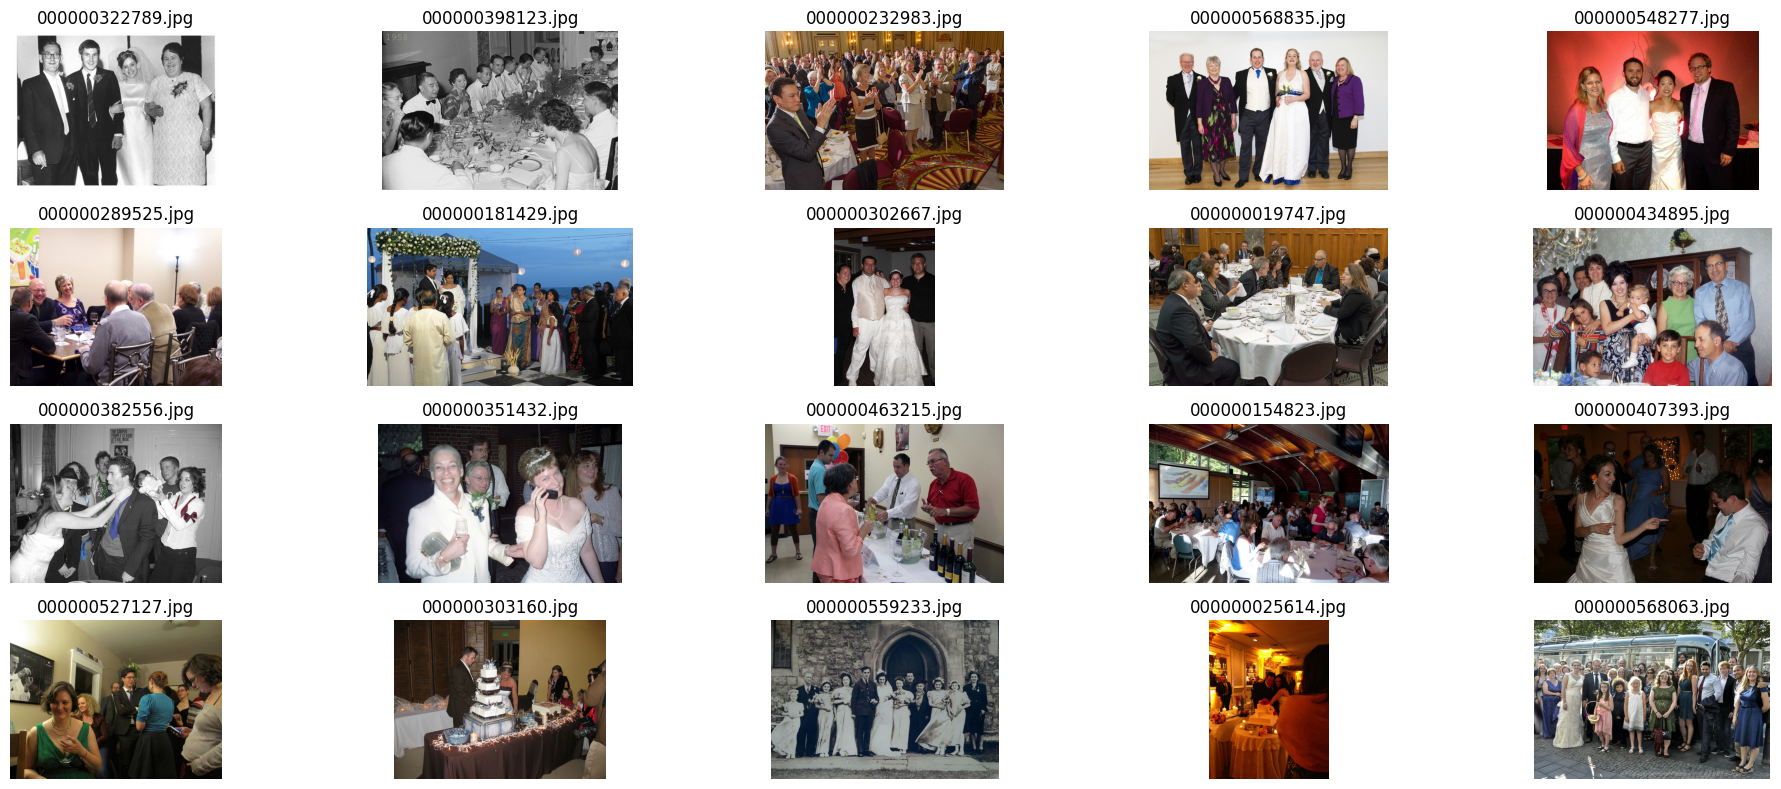

image_paths: ['./playground/data/css_data/unlabeled2017/000000322789.jpg', './playground/data/css_data/unlabeled2017/000000398123.jpg', './playground/data/css_data/unlabeled2017/000000232983.jpg', './playground/data/css_data/unlabeled2017/000000568835.jpg', './playground/data/css_data/unlabeled2017/000000548277.jpg', './playground/data/css_data/unlabeled2017/000000289525.jpg', './playground/data/css_data/unlabeled2017/000000181429.jpg', './playground/data/css_data/unlabeled2017/000000302667.jpg', './playground/data/css_data/unlabeled2017/000000019747.jpg', './playground/data/css_data/unlabeled2017/000000434895.jpg', './playground/data/css_data/unlabeled2017/000000382556.jpg', './playground/data/css_data/unlabeled2017/000000351432.jpg', './playground/data/css_data/unlabeled2017/000000463215.jpg', './playground/data/css_data/unlabeled2017/000000154823.jpg', './playground/data/css_data/unlabeled2017/000000407393.jpg', './playground/data/css_data/unlabeled2017/000000527127.jpg', './playgro

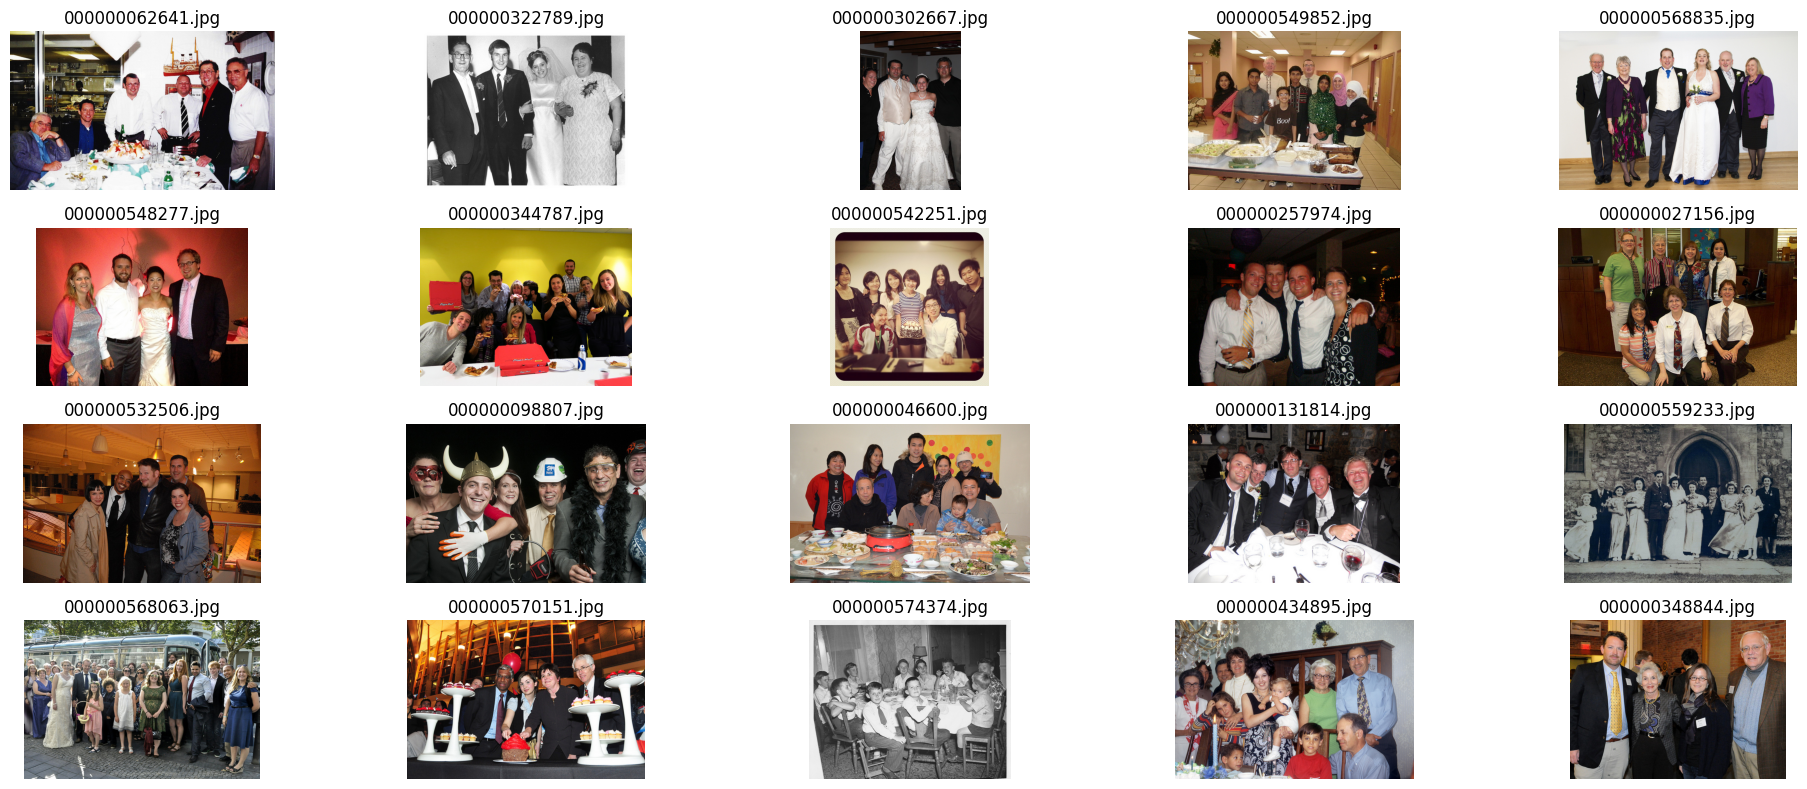

image_paths: ['./playground/data/css_data/unlabeled2017/000000062641.jpg', './playground/data/css_data/unlabeled2017/000000322789.jpg', './playground/data/css_data/unlabeled2017/000000302667.jpg', './playground/data/css_data/unlabeled2017/000000549852.jpg', './playground/data/css_data/unlabeled2017/000000568835.jpg', './playground/data/css_data/unlabeled2017/000000548277.jpg', './playground/data/css_data/unlabeled2017/000000344787.jpg', './playground/data/css_data/unlabeled2017/000000542251.jpg', './playground/data/css_data/unlabeled2017/000000257974.jpg', './playground/data/css_data/unlabeled2017/000000027156.jpg', './playground/data/css_data/unlabeled2017/000000532506.jpg', './playground/data/css_data/unlabeled2017/000000098807.jpg', './playground/data/css_data/unlabeled2017/000000046600.jpg', './playground/data/css_data/unlabeled2017/000000131814.jpg', './playground/data/css_data/unlabeled2017/000000559233.jpg', './playground/data/css_data/unlabeled2017/000000568063.jpg', './playgro

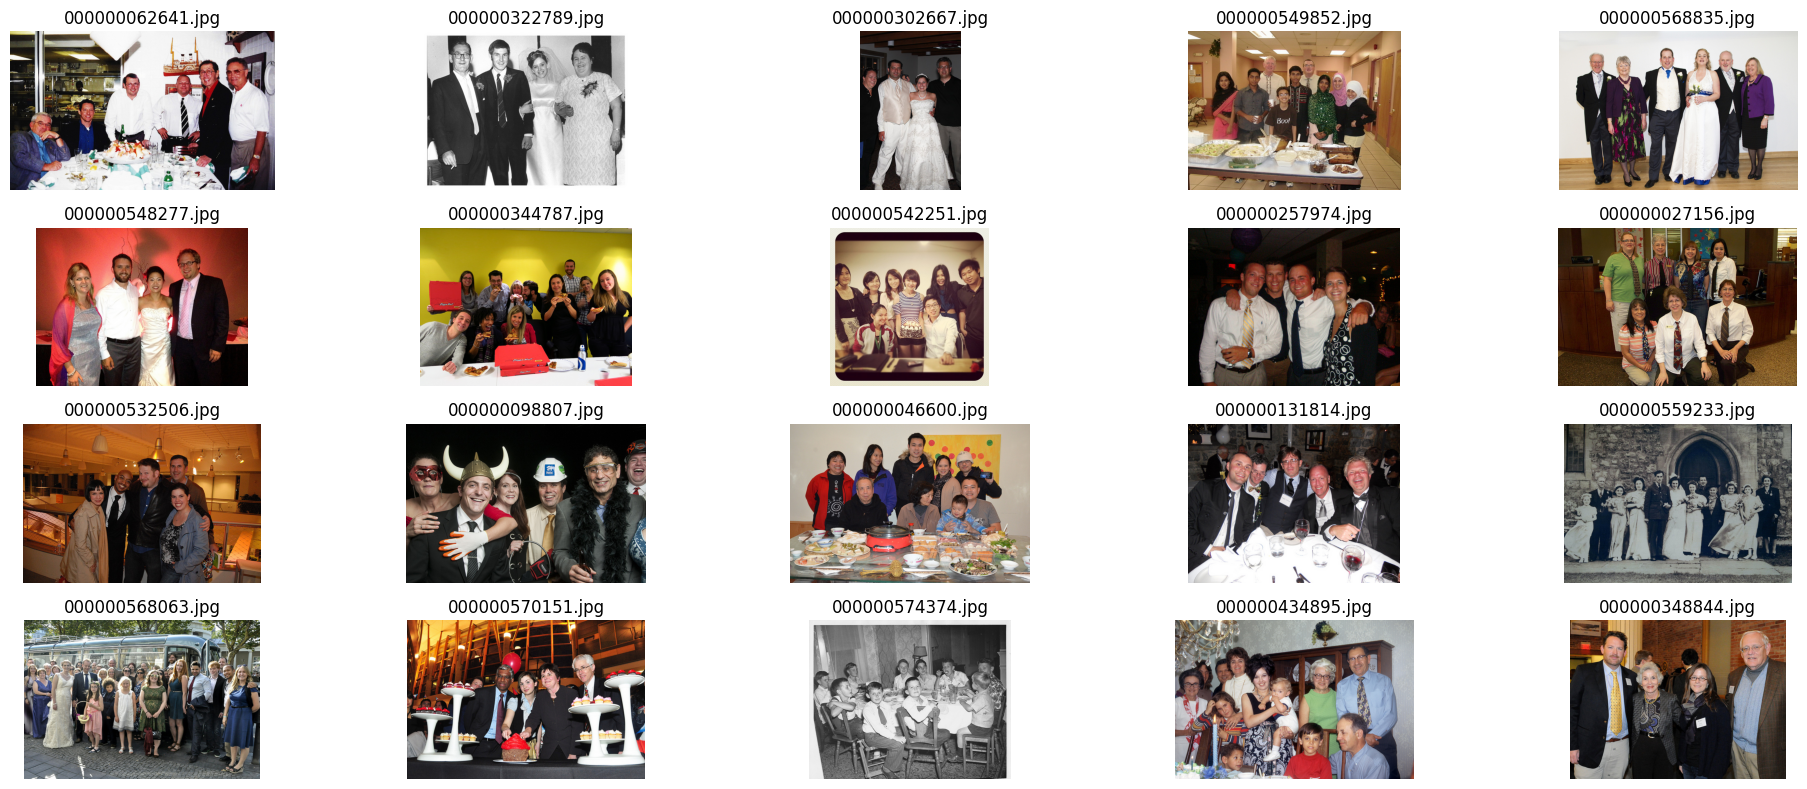

Final Best Rank improved from 350 to 6, Best Image Path: ./playground/data/css_data/unlabeled2017/000000322789.jpg


In [20]:

def run_sample_case(file_type, file_path=None, dataset_name=None, split=None):
    
    data_loader = get_data_loader(file_type, file_path=file_path, dataset_name=dataset_name, split=split)
    data = data_loader.load_data()  # LoadData

    print(data.shape)  
    
    
    i = 49
    
    query = data.iloc[i]["option"]  
    target_image_path = './playground/data/css_data/' + data.iloc[i]["target_image"]  
    
    
    image_paths, indices = retrieve_topk_images([query], topk=1000, faiss_model=faiss_model, blip_model=dialog_encoder, id2image=id2image, processor=None)
    image_rank = find_index_in_list(target_image_path, image_paths[0])

    
    
    initial_rank = image_rank
    max_rounds = 5
    rank_threshold = 10
    round_number = 0
    accumulated_summary = ""
    previous_questions = [query]
    image_ranks_per_round = []
    
    
    query_with_feedback = "Initial Query: " + query + accumulated_summary  


    
    while round_number < max_rounds:
        round_number += 1
        print(f"Round {round_number}:")
        
        
        top_images_path = image_paths[0][:40]
        random_selection_path = random.sample(top_images_path, 5)
        base64_image_top = [encode_image(image_path) for image_path in random_selection_path]
        
        
        question = generate_valid_question(base64_image_top, system_prompt, previous_questions)
        previous_questions.append(question)
        
        
        base64_target_image = encode_image(target_image_path)
        answer_of_question = answer(question, base64_target_image)
        print(f'new -> question: {question}, answer_of_question: {answer_of_question}')
        
        print(f'query_with_feedback: {query_with_feedback}, question: {question}, answer_of_question: {answer_of_question}')
        
        
        accumulated_summary += f" Question: {question} Answer: {answer_of_question}"
        
        
        query_with_feedback = query_with_feedback+ accumulated_summary  
        print(f'query_with_feedback: {query_with_feedback}, ')
        
        
        summary_of_question_and_option = summary(query_with_feedback, question, answer_of_question)
        image_paths_new, indices = retrieve_topk_images([summary_of_question_and_option], topk=10000, faiss_model=faiss_model, blip_model=dialog_encoder, id2image=id2image, processor=None)
        
        
        image_rank_new = find_index_in_list(target_image_path, image_paths_new[0])
        image_ranks_per_round.append((image_rank_new, image_paths_new[0]))  
        
        
        print(f"Old Rank: {image_rank}, New Rank: {image_rank_new}")
        
        
        if image_rank_new < rank_threshold:
            print(f"Image rank ({image_rank_new}) is below the threshold ({rank_threshold}). Ending early.")
            show_image(image_paths[0][:20], sentence=None)
            break
        
        
        image_paths = image_paths_new
        image_rank = image_rank_new
        show_image(image_paths[0][:20], sentence=None)
        print(f'image_paths: {image_paths[0][:20]}')

    
    best_rank, best_image_paths = min(image_ranks_per_round, key=lambda x: x[0])  
    best_image_path = best_image_paths[0]  

    
    if best_rank < initial_rank:
        print(f"Final Best Rank improved from {initial_rank} to {best_rank}, Best Image Path: {best_image_path}")
    else:
        print(f"No significant improvement. Final Best Rank: {best_rank}, Best Image Path: {best_image_path}")
        
    # show_image(image_paths[0][:20], sentence=None)





run_sample_case(file_type="csv", file_path="/root/autodl-tmp/.autodl/HYF/questionIR/CSS/downloads/group_100-.csv")




In [20]:



folder_path = '/root/autodl-tmp/.autodl/HYF/questionIR/CSS/downloads/'
file_name_list = [
    'group_10-20.csv',
    'group_20-50.csv',
    'group_50-100.csv',
    'group_100-.csv'
]

In [21]:

def init_csv_file(output_file):
    fieldnames = [
        'file_name', 
        'query_number', 
        'initial_rank', 
        'best_rank', 
        'rounds', 
        'image_ranks_per_round', 
        'top_10_hits_before', 
        'top_10_hits_after',
        'queries_feedback'  
    ]
    with open(output_file, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
    return fieldnames


In [22]:

def save_results_to_csv(output_file, fieldnames, file_name, query_number, initial_rank, best_rank, rounds, image_ranks_per_round, top_10_hits_before, top_10_hits_after, queries_feedback):
    with open(output_file, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writerow({
            'file_name': file_name,
            'query_number': query_number,
            'initial_rank': initial_rank,
            'best_rank': best_rank,
            'rounds': rounds,
            'image_ranks_per_round': image_ranks_per_round,
            'top_10_hits_before': top_10_hits_before,
            'top_10_hits_after': top_10_hits_after,
            'queries_feedback': queries_feedback  
        })

In [26]:
import csv
from tqdm import tqdm

query_question = []


max_rounds = 5
rank_threshold = 10  


top_10_hits_before = 0  
top_10_hits_after = 0  
total_queries_accumulated = 0  


output_file = 'multi-round-result_Blip_FT_VisDial.csv'


fieldnames = init_csv_file(output_file)


for file_name in file_name_list:
    file_path = folder_path + file_name
    csv_data = read_csv(file_path)  
    total_queries = len(csv_data)  
    total_queries_accumulated += total_queries  
    

    top_10_hits_before_dataset = 0  
    top_10_hits_after_dataset = 0  
    
    


    for i in tqdm(range(total_queries)):
        query = csv_data["option"][i]  
        target_image_path = './playground/data/css_data/' + csv_data["target_image"][i]  
        

        image_ranks_per_round = []
        queries_feedback = []  
        

        image_paths, indices = retrieve_topk_images([query],
                                                    topk=50000,
                                                    faiss_model=faiss_model,
                                                    blip_model=dialog_encoder,
                                                    id2image=id2image,
                                                    processor=None)
        image_rank = find_index_in_list(target_image_path, image_paths[0])
        

        if image_rank < 10:
            top_10_hits_before += 1
            top_10_hits_before_dataset += 1


        initial_rank = image_rank
        

        accumulated_summary = ""
        previous_questions = [query]  
        query_with_feedback = "Initial Query: " + query + accumulated_summary  
        
        round_number = 0
        
        
        while round_number < max_rounds:
            round_number += 1

            top_images_path = image_paths[0][:40]
            random_selection_path = random.sample(top_images_path, 5)
            base64_image_top = [encode_image(image_path) for image_path in random_selection_path]
            

            question = generate_valid_question(base64_image_top, system_prompt, previous_questions)
            
            
            if question is None:
                print(f"Failed to generate a valid question for image {i+1}, skipping this sample.")
                continue
            
            query_question.append([query_with_feedback, question])
            previous_questions.append(question)  
            

            base64_target_image = encode_image(target_image_path)
            answer_of_question = answer(question, base64_target_image)
            

            accumulated_summary = f" Question: {question} Answer: {answer_of_question}"
            query_with_feedback += accumulated_summary
            
            
            
            
            summary_of_question_and_option = summary(query_with_feedback, question, answer_of_question)
            
            
            image_paths_new, indices = retrieve_topk_images([summary_of_question_and_option],
                                                            topk=50000,
                                                            faiss_model=faiss_model,
                                                            blip_model=dialog_encoder,
                                                            id2image=id2image,
                                                            processor=None)
            

            image_rank_new = find_index_in_list(target_image_path, image_paths_new[0])
            image_ranks_per_round.append(image_rank_new)  
            
            
            
            # print(f"Round {round_number + 1}: New Rank: {image_rank_new}, Old Rank: {image_rank},")
            
            
            if image_rank_new < rank_threshold:
                print(f"Image rank ({image_rank_new}) is below the threshold ({rank_threshold}). Ending early.")
                break  
            

            image_paths = image_paths_new
    
        queries_feedback.append({
                'query_with_feedback': query_with_feedback,
            })  

        best_rank = min(image_ranks_per_round)  
            
        
        if best_rank < 10:
            top_10_hits_after += 1
            top_10_hits_after_dataset += 1

        
        save_results_to_csv(
            output_file, 
            fieldnames, 
            file_name, 
            i + 1, 
            initial_rank, 
            best_rank, 
            round_number, 
            ','.join(map(str, image_ranks_per_round)), 
            top_10_hits_before_dataset, 
            top_10_hits_after_dataset,
            queries_feedback  
        )
        
        
    
    top_10_recall_rate_before_dataset = top_10_hits_before_dataset / total_queries
    top_10_recall_rate_after_dataset = top_10_hits_after_dataset / total_queries
    print(f'Dataset: {file_name} - Top-10 hits before multi-round: {top_10_hits_before_dataset}, total_queries: {total_queries}')
    print(f"Dataset: {file_name} - Top-10 Recall Rate before multi-round: {top_10_recall_rate_before_dataset * 100:.4f}%")
    print(f'Dataset: {file_name} - Top-10 hits after multi-round: {top_10_hits_after_dataset}, total_queries: {total_queries}')
    print(f"Dataset: {file_name} - Top-10 Recall Rate after multi-round: {top_10_recall_rate_after_dataset * 100:.4f}%")
    print('---------------------------------------')
    

top_10_recall_rate_before = top_10_hits_before / total_queries_accumulated
top_10_recall_rate_after = top_10_hits_after / total_queries_accumulated
print(f'top_10_hits before multi-round: {top_10_hits_before}, total_queries_accumulated: {total_queries_accumulated}')
print(f"Top-10 Recall Rate before multi-round: {top_10_recall_rate_before * 100:.4f}%")
print(f'top_10_hits after multi-round: {top_10_hits_after}, total_queries_accumulated: {total_queries_accumulated}')
print(f"Top-10 Recall Rate after multi-round: {top_10_recall_rate_after * 100:.4f}%")





处理Data集: group_10-20.csv, 总共 5 个查询


  0%|          | 0/5 [00:00<?, ?it/s]

faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)
faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)
faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)
faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)


 20%|██        | 1/5 [00:54<03:37, 54.37s/it]

faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)
Image rank (0) is below the threshold (10). Ending early.
第 1 张图片的测试结果已保存到 CSV。
faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)


 40%|████      | 2/5 [01:09<01:34, 31.51s/it]

faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)
Image rank (7) is below the threshold (10). Ending early.
第 2 张图片的测试结果已保存到 CSV。
faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)


 60%|██████    | 3/5 [01:25<00:48, 24.16s/it]

faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)
Image rank (1) is below the threshold (10). Ending early.
第 3 张图片的测试结果已保存到 CSV。
faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)
faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)


 80%|████████  | 4/5 [01:54<00:26, 26.18s/it]

faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)
Image rank (3) is below the threshold (10). Ending early.
第 4 张图片的测试结果已保存到 CSV。
faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)
faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)
faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)
faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)


100%|██████████| 5/5 [02:56<00:00, 35.21s/it]


faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)
Image rank (7) is below the threshold (10). Ending early.
第 5 张图片的测试结果已保存到 CSV。
Dataset: group_10-20.csv - Top-10 hits before multi-round: 0, total_queries: 5
Dataset: group_10-20.csv - Top-10 Recall Rate before multi-round: 0.0000%
Dataset: group_10-20.csv - Top-10 hits after multi-round: 5, total_queries: 5
Dataset: group_10-20.csv - Top-10 Recall Rate after multi-round: 100.0000%
---------------------------------------
处理Data集: group_20-50.csv, 总共 5 个查询


  0%|          | 0/5 [00:00<?, ?it/s]

faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)
faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)
faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)
faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)
faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)


 20%|██        | 1/5 [01:08<04:35, 68.81s/it]

faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)
第 1 张图片的测试结果已保存到 CSV。
faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)
faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)
faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)
faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)
faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)


 40%|████      | 2/5 [02:20<03:31, 70.65s/it]

faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)
第 2 张图片的测试结果已保存到 CSV。
faiss_model vector dimension (d): 256
Query vector dimension: (1, 256)


 40%|████      | 2/5 [02:22<03:34, 71.46s/it]


KeyboardInterrupt: 